In [8]:
import sys
import os
import yaml
import itertools
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import shutil
import yaml

In [23]:
import torch
from torch import nn
import warnings

class LSTMModel(nn.Module):
    def __init__(self, model_structure: dict):
        """
        Initialize the LSTM model using the model_structure dictionary.
        
        Parameters
        ----------
        model_structure : dict
            Dictionary containing the model structure.
            1. input_features : int
            Number of input features.
            
            2. sequence_length : int
            Length of the input sequences.
            
            3. hidden_size : int
            Number of hidden units in the LSTM.
            
            4. num_layers : int
            Number of LSTM layers.

            5. output_size : int

            Number of Outputs for the linear layer
        """
        super(LSTMModel, self).__init__()
        self.build_model_structure(model_structure)

    def build_model_structure(self, model_structure: dict):
        """
        Build the model from the structure dictionary and set up the layers.
        
        Parameters
        ----------
        model_structure : dict
            Dictionary containing the model structure with the following keys:
            1. input_features : int
            Number of input features.
            
            2. sequence_length : int
            Length of the input sequences.
            
            3. hidden_size : int
            Number of hidden units in the LSTM.
            
            4. num_layers : int
            Number of LSTM layers.
        """
        if model_structure is None:
            model_structure = {}
        self.structure_consistency_check(model_structure)
        
        self.input_features = model_structure["input_features"]
        self.sequence_length = model_structure["sequence_length"]
        self.hidden_size = model_structure["hidden_size"]
        self.num_layers = model_structure["num_layers"]
        self.output_size = model_structure["output_size"]

        self.lstm_layer = nn.LSTM(input_size=self.input_features, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)

    def initialize_hidden_state(self, batch_size, dtype, device=torch.device("cpu")):
        """
        Initialize the hidden and cell states for the LSTM.
        
        Parameters
        ----------
        batch_size : int
            Size of the batch for which the hidden state is initialized.
        """
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size,device=device,dtype=dtype)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size,device=device,dtype=dtype)
        self.hidden = (hidden_state, cell_state)

    def forward(self, x):
        """
        Forward pass through the LSTM model.
        
        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, sequence_length, input_features).
        
        Returns
        -------
        torch.Tensor
            Output tensor of shape (batch_size, 1).
        """
        batch_size, seq_len, _ = x.size()
        lstm_out, self.hidden = self.lstm_layer(x, self.hidden)
        #lstm_out = lstm_out.contiguous().view(batch_size, -1)
        return self.output_layer(lstm_out[:, -1, :])

    def structure_consistency_check(self, model_structure: dict):
        """
        Check if the model structure follows the expected standards and set defaults if not.
        
        Parameters
        ----------
        model_structure : dict
            Dictionary of the model structure.
        
        Raises
        ------
        UserWarning
            If a parameter is not in the expected format.
        """
        default_input_features = 1
        default_sequence_length = 10
        default_hidden_size = 20
        default_num_layers = 1
        default_output_size = 1

        if "input_features" not in model_structure:
            model_structure["input_features"] = default_input_features
            warnings.warn(
                "The model loaded does not define the input features as expected. Changed it to default value: {}.".format(default_input_features)
            )
        else:
            input_features = model_structure.get('input_features')
            assert isinstance(input_features, int) and input_features > 0, "input_features must be a positive integer"

        if "sequence_length" not in model_structure:
            model_structure["sequence_length"] = default_sequence_length
            warnings.warn(
                "The model loaded does not define the sequence length as expected. Changed it to default value: {}.".format(default_sequence_length)
            )
        else:
            sequence_length = model_structure.get('sequence_length')
            assert isinstance(sequence_length, int) and sequence_length > 0, "sequence_length must be a positive integer"

        if "hidden_size" not in model_structure:
            model_structure["hidden_size"] = default_hidden_size
            warnings.warn(
                "The model loaded does not define the hidden size as expected. Changed it to default value: {}.".format(default_hidden_size)
            )
        else:
            hidden_size = model_structure.get('hidden_size')
            assert isinstance(hidden_size, int) and hidden_size > 0, "hidden_size must be a positive integer"

        if "num_layers" not in model_structure:
            model_structure["num_layers"] = default_num_layers
            warnings.warn(
                "The model loaded does not define the number of layers as expected. Changed it to default value: {}.".format(default_num_layers)
            )
        else:
            num_layers = model_structure.get('num_layers')
            assert isinstance(num_layers, int) and num_layers > 0, "num_layers must be a positive integer"

        if "output_size" not in model_structure:
            model_structure["output_size"] = default_output_size
            warnings.warn(
                "The model loaded does not define the number of outputs as expected. Changed it to default value: {}.".format(default_output_size)
            )
        else:
            output_size = model_structure.get('output_size')
            assert isinstance(output_size, int) and output_size > 0, "num_layers must be a positive integer"



def load_configs(file_name: str):
    """
    Loads a yaml file from the given file path.

    Parameters
    ----------
    file_name : str
        File object or path to yaml file.

    Returns
    -------
    dict : Python dictionary with formatted yaml data.

    Example
    --------
    file = "boolean.yaml"
    data = load_configs(file)

    """
    with open(file_name) as f:
        return yaml.load(f, Loader=IncludeLoader)


class IncludeLoader(yaml.Loader):
    """
    Class to handle !include directives in config files.
    This allows you to load the contents of a file from within a file
    and therefore multiple files can be loaded into a dict by simply 
    using !include "filename/filepath"

    When constructed with a file object, the root path for "include"
    defaults to the directory containing the file, otherwise to the current
    working directory. In either case, the root path can be overridden by the
    `root` keyword argument. When an included file F contain its own !include
    directive, the path is relative to F's location.

    Example
    --------
    Given two yaml files file1.yaml and file2.yaml
    file1.yaml -

    >>> processor : simulation
    >>> algorithm : !include file2.yaml

    file2.yaml -

    >>> optimizer : genetic

    When loading file1.yaml, you will get a dictionary in which file2.yaml
    is already incorporated:

    >>> file = open(self.path + "file1.yaml", "r") --loading the file
    >>> loader = IncludeLoader(file)
    >>> data = loader.get_data()

    The result is a data : dict with the following keys and values of data:
    >>>     processor : simulation
    >>>     algorithm :
    >>>             optimizer : genetic
    """
    def __init__(self, *args, **kwargs):
        """
        Constructor to initialize the file root and load the file
        """
        super(IncludeLoader, self).__init__(*args, **kwargs)
        self.add_constructor("!include", self._include)
        # if "root" in kwargs:
        #     self.root = kwargs["root"]
        #if isinstance(self.stream, io.TextIOWrapper):
        self.root = os.path.dirname(self.stream.name)
        #else:
        #    self.root = os.path.curdir

    def _include(self, loader, node):
        """
        The method is used to load a file from within a file.
        It can be invoked by simply using the !include directive inside a file.
        Therefore the data of multiple files can be loaded together
        into a dict by loading just one file with this class.

        Parameters
        ----------
        loader : IncludeLoader
            loader object to construct a scalar node to the !include file
        node : str
            file path

        Returns
        -------
        dict
            loaded file as a python dictionary
        """
        oldRoot = self.root
        filename = os.path.join(self.root, loader.construct_scalar(node))
        self.root = os.path.dirname(filename)
        self.root = oldRoot
        with open(filename, "r") as f:
            return yaml.load(f, Loader=yaml.FullLoader)


In [24]:

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Generate synthetic sine wave data
t = np.linspace(0, 100, 1000)
data = np.sin(t)

# Function to create sequences
def prepare_rnn_sequences(data, sequence_length):
    input_sequences, target_values = [], []
    for start_idx in range(len(data) - sequence_length):
        input_seq = data[start_idx:start_idx + sequence_length]
        target_value = data[start_idx + sequence_length - 1]
        input_sequences.append(input_seq)
        target_values.append(target_value)
    return np.array(input_sequences), np.array(target_values)

seq_length = 10
X, y = prepare_rnn_sequences(data, seq_length)

# Convert data to PyTorch tensors
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)


In [25]:
smg_configs = load_configs('smg_configs_template_omar.yaml')

model = LSTMModel(smg_configs)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    model.initialize_hidden_state(trainX.size(0), trainX.dtype)
    outputs = model(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\Users\omarm\AppData\Local\Temp\ipykernel_12516\1631194634.py:120: UserWarning: The model loaded does not define the input features as expected. Changed it to default value: 1.
  warnings.warn(
C:\Users\omarm\AppData\Local\Temp\ipykernel_12516\1631194634.py:129: UserWarning: The model loaded does not define the sequence length as expected. Changed it to default value: 10.
  warnings.warn(
C:\Users\omarm\AppData\Local\Temp\ipykernel_12516\1631194634.py:138: UserWarning: The model loaded does not define the hidden size as expected. Changed it to default value: 20.
  warnings.warn(
C:\Users\omarm\AppData\Local\Temp\ipykernel_12516\1631194634.py:147: UserWarning: The model loaded does not define the number of layers as expected. Changed it to default value: 1.
  warnings.warn(
C:\Users\omarm\AppData\Local\Temp\ipykernel_12516\1631194634.py:156: UserWarning: The model loaded does not define the number of outputs as expected. Changed it to default value: 1.
  warnings.warn(


Epoch [10/100], Loss: 0.0694
Epoch [20/100], Loss: 0.0420
Epoch [30/100], Loss: 0.0109
Epoch [40/100], Loss: 0.0029
Epoch [50/100], Loss: 0.0009
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


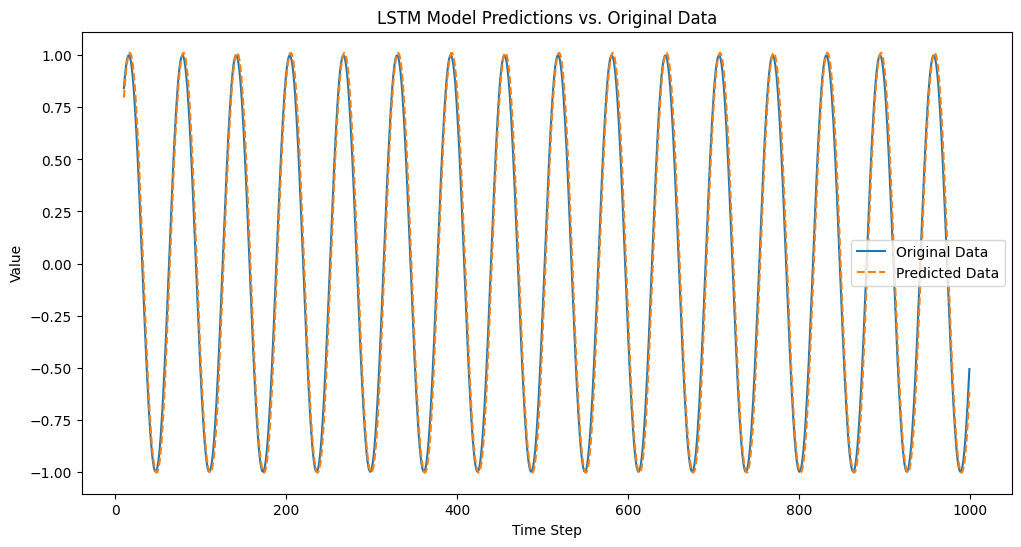

In [26]:
# Predicted outputs
model.eval()
predicted = model(trainX).detach().numpy()

# Adjusting the original data and prediction for plotting
# The prediction corresponds to the point just after each sequence
original = data[seq_length:]  # Original data from the end of the first sequence
time_steps = np.arange(seq_length, len(data))  # Corresponding time steps

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted, label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()